# Multi-strain modeling

In [1]:
import pandas
import glob
import cobra

from IPython.display import Image 
import pydotplus
from sklearn.externals.six import StringIO  

from sklearn import tree
import graphviz 

import seaborn

from qbio_resources.multistrain_info import carbon_sources,  strain_classification, phosphorus_sources
%matplotlib inline

/Users/coltonlloyd/Envs/qbio18/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/coltonlloyd/Envs/qbio18/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


----
## A) Simulating growth w/ multi strain models

The goal of this exercise is to provide an introduction to multi-strain metabolic modeling of the E. coli species. The following is largely take from

"Monk, J. M., Charusanti, P., Aziz, R. K., Lerman, J. a, Premyodhin, N., Orth, J. D., … Palsson, B. Ø. (2013). Genome-scale metabolic reconstructions of multiple Escherichia coli strains highlight strain-specific adaptations to nutritional environments. Proceedings of the National Academy of Sciences, 110(50), 20338–20343. http://doi.org/10.1073/pnas.1307797110" 

In the interest of time, only 20 of the models from this study will be used.

### 1) Using 20 models, simulate growth on the 78 carbon containing nutrients in `carbon_sources` and output all predicted growth rates in a dataframe.

The first step in the multi-strain analysis is to quantify the catabolic capabilities of each of the strains in terms of the metabolites that they are capable of growing on.

- The carbon sources are listed below. These are all of the metabolites that show variable growth capabilities among the strains.

- The simulations should take about 3 minutes to run.

- Do not forget to set the lower_bound of glucose uptake to 0 before simulating with the new carbon source

In [2]:
print(carbon_sources)

['EX_12ppd__S_e', 'EX_14glucan_e', 'EX_3hcinnm_e', 'EX_3hpppn_e', 'EX_5dglcn_e', 'LalaDgluMdap_e', 'EX_acac_e', 'EX_acgal_e', 'EX_acgal1p_e', 'EX_akg_e', 'all__D_e', 'EX_alltn_e', 'EX_arab__L_e', 'EX_ascb__L_e', 'EX_but_e', 'EX_butso3_e', 'chol_e', 'EX_csn_e', 'EX_cys__D_e', 'EX_etha_e', 'EX_fald_e', 'EX_fe3dcit_e', 'frulys_e', 'EX_fruur_e', 'EX_fuc__L_e', 'EX_g1p_e', 'EX_gal_e', 'EX_gal_bD_e', 'gal1p_e', 'EX_galct__D_e', 'EX_galctn__D_e', 'EX_galctn__L_e', 'EX_galt_e', 'galur_e', 'EX_glcur_e', 'EX_glcur1p_e', 'EX_glyclt_e', 'EX_idon__L_e', 'lyx__L_e', 'EX_malt_e', 'EX_malthx_e', 'EX_maltpt_e', 'EX_malttr_e', 'maltttr_e', 'EX_manglyc_e', 'EX_melib_e', 'EX_orot_e', 'EX_pacald_e', 'EX_peamn_e', 'ppa_e', 'EX_ppal_e', 'EX_pppn_e', 'EX_psclys_e', 'EX_r5p_e', 'EX_rib__D_e', 'rmn_e', 'EX_sbt__D_e', 'EX_sucr_e', 'EX_tartr__D_e', 'EX_trp__L_e', 'EX_uacgam_e', 'udpacgal_e', 'EX_udpg_e', 'EX_udpgal_e', 'EX_udpglcur_e', 'EX_ura_e', 'EX_xan_e', 'xyl__D_e', 'EX_xylu__L_e', 'EX_4hphac_e', 'EX_4hthr_e

**Hints:**
  
1) The models are contained in the `multi_strain_models` directory and their filepaths can be listed using `glob`
 - Each model can be loded from the filepath in this list using `cobra.io.load_json_model(filepath)`

In [3]:
print(glob.glob('../qbio_resources/multi_strain_models/*.json'))

['../qbio_resources/multi_strain_models/iAPECO1_1312.json', '../qbio_resources/multi_strain_models/iB21_1397.json', '../qbio_resources/multi_strain_models/iBWG_1329.json', '../qbio_resources/multi_strain_models/ic_1306.json', '../qbio_resources/multi_strain_models/iE2348C_1286.json', '../qbio_resources/multi_strain_models/iEC042_1314.json', '../qbio_resources/multi_strain_models/iEC55989_1330.json', '../qbio_resources/multi_strain_models/iECABU_c1320.json', '../qbio_resources/multi_strain_models/iECB_1328.json', '../qbio_resources/multi_strain_models/iECBD_1354.json', '../qbio_resources/multi_strain_models/iECD_1391.json', '../qbio_resources/multi_strain_models/iECDH10B_1368.json', '../qbio_resources/multi_strain_models/iEcDH1_1363.json', '../qbio_resources/multi_strain_models/iECDH1ME8569_1439.json', '../qbio_resources/multi_strain_models/iEcE24377_1341.json', '../qbio_resources/multi_strain_models/iECED1_1282.json', '../qbio_resources/multi_strain_models/iECH74115_1262.json', '../qbi

2) The most conventient way to output the results is as a `pandas.DataFrame` (table) 
  - You can then update the values in the table by row and column name using the following

In [4]:
# Initialize an empty DataFram
test_df = pandas.DataFrame()

# Add new value
test_df.loc['Row 0', 'Column 0'] = 5
test_df.loc['Row 1', 'Column 0'] = 10
test_df.loc['Row 1', 'Column 1'] = 2
test_df

,Column 0,Column 1
Row 0,5.0,NaN
Row 1,10.0,2.0


3) When optimizing the model, it is quicker to use `slim_optimize`. This will return only the growth rate of the simulation

In [5]:
# Load model
model = cobra.io.load_json_model('../qbio_resources/iML1515.json')

# Change carbon source
model.reactions.EX_glc__D_e.lower_bound = 0
model.reactions.EX_ac_e.lower_bound = -10
growth_rate = model.slim_optimize() 
print(growth_rate)

0.21009920466530235


4) Do not forget to set the lower bound of the exchange reaction **back to zero** after simulating!

In [6]:
df = pandas.DataFrame()
for m in glob.glob('../qbio_resources/multi_strain_models/*.json'):
    model = cobra.io.load_json_model(m)
    model.reactions.EX_glc__D_e.lower_bound = 0
    print(model.id, model.name)
    for r_id in carbon_sources:
        if r_id not in model.reactions:
            continue
        r = model.reactions.get_by_id(r_id)

        r.lower_bound = -10
        df.loc[r.id, model.id] = model.slim_optimize()
        r.lower_bound = 0

iAPECO1_1312 Escherichia coli APEC O1
iB21_1397 Escherichia coli BL21(DE3)
iBWG_1329 Escherichia coli BW2952
ic_1306 Escherichia coli CFT073
iE2348C_1286 Escherichia coli O127:H6 str. E2348/69
iEC042_1314 Escherichia coli 042
iEC55989_1330 Escherichia coli 55989
iECABU_c1320 Escherichia coli ABU 83972
iECB_1328 Escherichia coli B str. REL606
iECBD_1354 Escherichia coli 'BL21-Gold(DE3)pLysS AG'
iECD_1391 Escherichia coli BL21(DE3)
iECDH10B_1368 Escherichia coli str. K-12 substr. DH10B
iEcDH1_1363 Escherichia coli DH1
iECDH1ME8569_1439 Escherichia coli DH1
iEcE24377_1341 Escherichia coli E24377A
iECED1_1282 Escherichia coli ED1a
iECH74115_1262 Escherichia coli O157:H7 str. EC4115
iEcHS_1320 Escherichia coli HS
iECIAI1_1343 Escherichia coli IAI1
iECIAI39_1322 Escherichia coli IAI39


### 2) Save output of the dataframe as a csv to save progress with `dataframe_name.to_csv(filename)`

In [7]:
df.to_csv('ecoli_growth_support.csv')

In [8]:
df = pandas.read_csv('ecoli_growth_support.csv', index_col=0)

### 3) Process the dataframe by removing `nan` values and applying growth threshold
Use .1 as the growth rate threshold
- Set dataframe growth rate values less than .1 equal to 0
- Set dataframe growth rate values greater than or equal to .1 equal to 1

**Hints:**
1) to avoid losing the simulation results during filtering first make a copy of the dataframe like below

In [9]:
filter_df = df.copy()

2) The dataframe has nan values if the metabolite/uptake reaction is not present in the model. You can fill nan values to zero with

In [10]:
filter_df.fillna(0, inplace=True)

3) You can edit values in a dataframe based on a filtering criteria (in this case values les than .5) using the following

In [11]:
filter_df[filter_df < .5] = 0

In [12]:
filter_df = df.copy()
filter_df.fillna(0, inplace=True)
filter_df[filter_df < .1] = 0
filter_df[filter_df >= .1] = 1

### 4) Print the new dataframe to make sure the changes were correctly made

In [13]:
filter_df

,iAPECO1_1312,iB21_1397,iBWG_1329,ic_1306,iE2348C_1286,iEC042_1314,iEC55989_1330,iECABU_c1320,iECB_1328,iECBD_1354,iECD_1391,iECDH10B_1368,iEcDH1_1363,iECDH1ME8569_1439,iEcE24377_1341,iECED1_1282,iECH74115_1262,iEcHS_1320,iECIAI1_1343,iECIAI39_1322
EX_12ppd__S_e,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
EX_14glucan_e,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
EX_3hcinnm_e,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
EX_3hpppn_e,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
EX_5dglcn_e,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
EX_acac_e,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
EX_acgal_e,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
EX_acgal1p_e,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
EX_akg_e,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
EX_alltn_e,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0


---
## B) Visualizing the results

This section will take the results dataframe from section A and visualize it as a clustered heatmap using `seaborn`

### 1) For visual purposes, transpose the dataframe so that the model IDs are listed in the rows
**Hint:** Dataframe's have a  `dataframe_name.T` property that return a transposed version of the dictionary.

In [14]:
filter_df = filter_df.T

### 2) Assign colors for each strain based on its type. This will be used to color the rows of the heatmap
Return a dictionary of the form ```strain_color_dict = {model_id: color}```

The collection of strains include the following types:
 1.  **Commensal strains** (lab strains that are not pathogenic)
 2.  **ExPec strains** (Extraintestinal pathogenic strains)
 3.  **InPec strains** (Intestinal pathogenics strains)
 
 
**Hints:**

1) The strain types can be colored according the following dictionary.
 - 'r' corresponds to red
 - 'b' corresponds to blue
 - 'g' corresponds to green

In [15]:
map_dict = {'Commensal': 'r', 'ExPec': 'b', 'InPec': 'g'}

2) The strain classifications per model id can be found in `strain_classification`

In [16]:
print(strain_classification)

{'iLF82_1304': 'InPec', 'iNRG857_1313': 'InPec', 'iUMN146_1321': 'InPec', 'iAPECO1_1312': 'ExPec', 'iEcolC_1368': 'Commensal', 'iECB_1328': 'Commensal', 'iECBD_1354': 'Commensal', 'iB21_1397': 'Commensal', 'iECD_1391': 'Commensal', 'iBWG_1329': 'Commensal', 'iEcDH1_1363': 'Commensal', 'iECDH1ME8569_1439': 'Commensal', 'iECED1_1282': 'Commensal', 'iEcHS_1320': 'Commensal', 'iECIAI1_1343': 'Commensal', 'iEKO11_1354': 'Commensal', 'iECSE_1348': 'Commensal', 'iECSF_1327': 'Commensal', 'iECDH10B_1368': 'Commensal', 'iJO1366': 'Commensal', 'iY75_1357': 'Commensal', 'iECW_1372': 'Commensal', 'iWFL_1372': 'Commensal', 'iEC042_1314': 'InPec', 'iEC55989_1330': 'InPec', 'iECO103_1326': 'InPec', 'iECO111_1330': 'InPec', 'iECH74115_1262': 'InPec', 'iZ_1308': 'InPec', 'iECs_1301': 'InPec', 'iECSP_1301': 'InPec', 'iECO26_1355': 'InPec', 'iG2583_1286': 'InPec', 'iEcSMS35_1347': 'ExPec', 'iE2348C_1286': 'InPec', 'iEcE24377_1341': 'InPec', 'iETEC_1333': 'InPec', 'iUMNK88_1353': 'InPec', 'iECOK1_1307': '

3) Dictionaries can be edited like below:

In [17]:
test_dict = {}
test_dict['key_1'] = 'value_1'
print(test_dict)

{'key_1': 'value_1'}


In [18]:
strain_color_dict = {}
for strain in strain_classification:
    strain_color_dict[strain] =  map_dict[strain_classification[strain]]

### 3) Return a list of colors based on the strains position in the dataframe's rows (or `index`)
**Hint:** You can map a dictionary to a dataframe's index using the following command and `test_df` from above

In [19]:
test_dict_for_mapping = {'Row 0': 'value_0', 'Row 1': 'value_1'}
print(test_df.index)
print(test_df.index.map(test_dict_for_mapping))

Index(['Row 0', 'Row 1'], dtype='object')
Index(['value_0', 'value_1'], dtype='object')


In [20]:
row_colors = filter_df.index.map(strain_color_dict)

### 4) Use the `seaborn.clustermap()` function to output the clustered heatmap

- Set figsize=(15,15)
- Set row_colors equal to the list that was returned in part 3, above

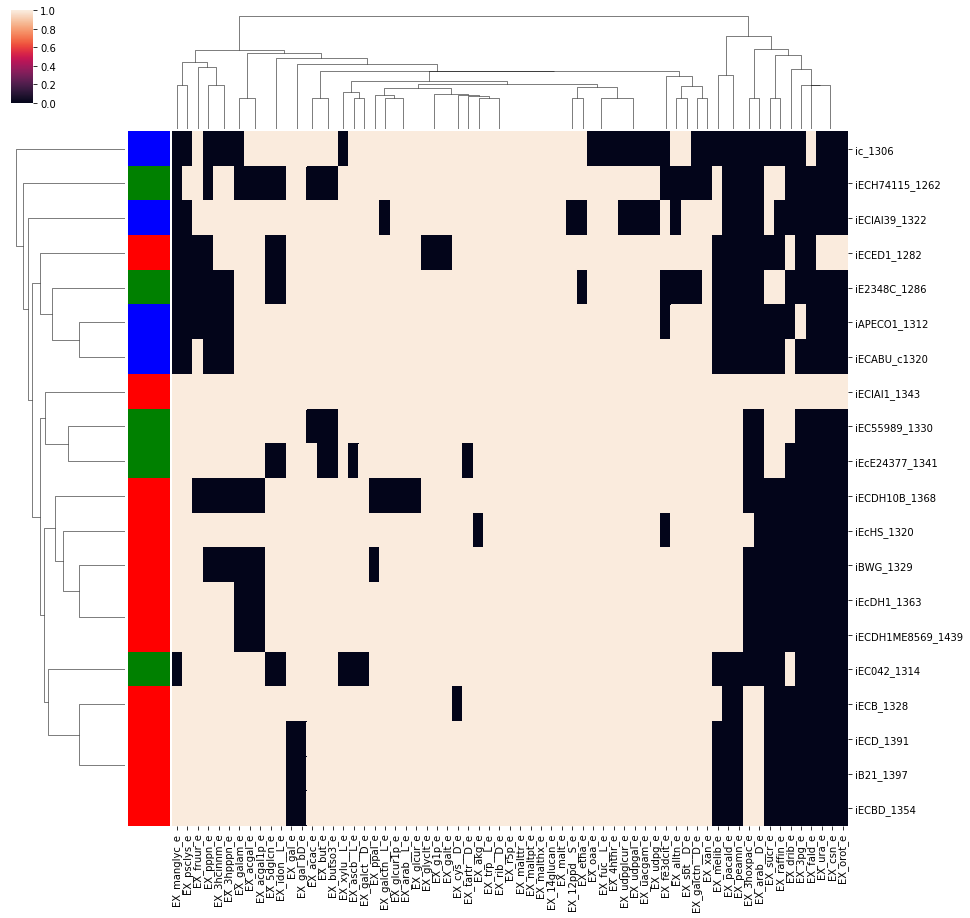

In [21]:
seaborn.clustermap(filter_df,  figsize=(15, 15), row_colors=row_colors)

## C) Machine learning to distinguish the strains
Now that we know that the strains do in fact have different growth capabilities. This section will demonstrate how machine learning methods, namely a decision tree, can predict how the strains could be separated based on growth conditions.

### 1) Create numerical classifiers for the strains in the dataframe

Create a list with 0s, 1s, and 2s corresponding to whether a row (`index`) in the dataframe corresponds to a Commensal, ExPec, or InPec strain, respectively.

**Hints:** 
1) You can use the following dictionaries to map the model id contained in the dataframe indexes to the numerical value

In [22]:
map_dict = {'Commensal': 0, 'ExPec': 1, 'InPec': 2}

In [23]:
print(strain_classification)

{'iLF82_1304': 'InPec', 'iNRG857_1313': 'InPec', 'iUMN146_1321': 'InPec', 'iAPECO1_1312': 'ExPec', 'iEcolC_1368': 'Commensal', 'iECB_1328': 'Commensal', 'iECBD_1354': 'Commensal', 'iB21_1397': 'Commensal', 'iECD_1391': 'Commensal', 'iBWG_1329': 'Commensal', 'iEcDH1_1363': 'Commensal', 'iECDH1ME8569_1439': 'Commensal', 'iECED1_1282': 'Commensal', 'iEcHS_1320': 'Commensal', 'iECIAI1_1343': 'Commensal', 'iEKO11_1354': 'Commensal', 'iECSE_1348': 'Commensal', 'iECSF_1327': 'Commensal', 'iECDH10B_1368': 'Commensal', 'iJO1366': 'Commensal', 'iY75_1357': 'Commensal', 'iECW_1372': 'Commensal', 'iWFL_1372': 'Commensal', 'iEC042_1314': 'InPec', 'iEC55989_1330': 'InPec', 'iECO103_1326': 'InPec', 'iECO111_1330': 'InPec', 'iECH74115_1262': 'InPec', 'iZ_1308': 'InPec', 'iECs_1301': 'InPec', 'iECSP_1301': 'InPec', 'iECO26_1355': 'InPec', 'iG2583_1286': 'InPec', 'iEcSMS35_1347': 'ExPec', 'iE2348C_1286': 'InPec', 'iEcE24377_1341': 'InPec', 'iETEC_1333': 'InPec', 'iUMNK88_1353': 'InPec', 'iECOK1_1307': '

2) You can loop through a dataframes rows (`indexes`) using the following procedure

In [24]:
for i in test_df.index:
    print(i)

Row 0
Row 1


In [25]:
targets = []
for i in filter_df.index:
    targets.append(map_dict[strain_classification[i]])

### 2) Initialize a new `tree.DecisionTreeClassifier` instance

- Set the max_depth=3. This determines how many decisions the tree can contain
- Assign the instance to a variable named `classifier`

In [26]:
classifier = tree.DecisionTreeClassifier(max_depth=3)

### 3) Build the decision tree classifier
- This can be executed with `classifier.fit()` where the filtered dataframe from above is the first argument and the list of numerical classifiers from part C1 is the second argument
- Assign the output to a variable named `fit_classifier`

In [27]:
fit_classifier = classifier.fit(filter_df, targets)

### 4) Pass the fit decision tree classifier into the function below to visualize the tree

In [28]:
def visualize_classification_tree(fit_classifier, filtered_dataframe):
    dot_data = StringIO()
    model = cobra.io.load_json_model('../qbio_resources/iML1515.json')
    map_dict = {'Commensal': 0, 'ExPec': 1, 'InPec': 2}
    # Get the full names of each of the columns
    feature_names = []
    for i in filtered_dataframe.columns:
        met_id = i.replace('EX_', '')
        if met_id in model.metabolites:
            feature_names.append(model.metabolites.get_by_id(met_id).name)
        else:
            feature_names.append('')
    tree.export_graphviz(fit_classifier, out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True, feature_names=feature_names,
                    class_names = list(map_dict.keys())) 
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    return Image(graph.create_png())

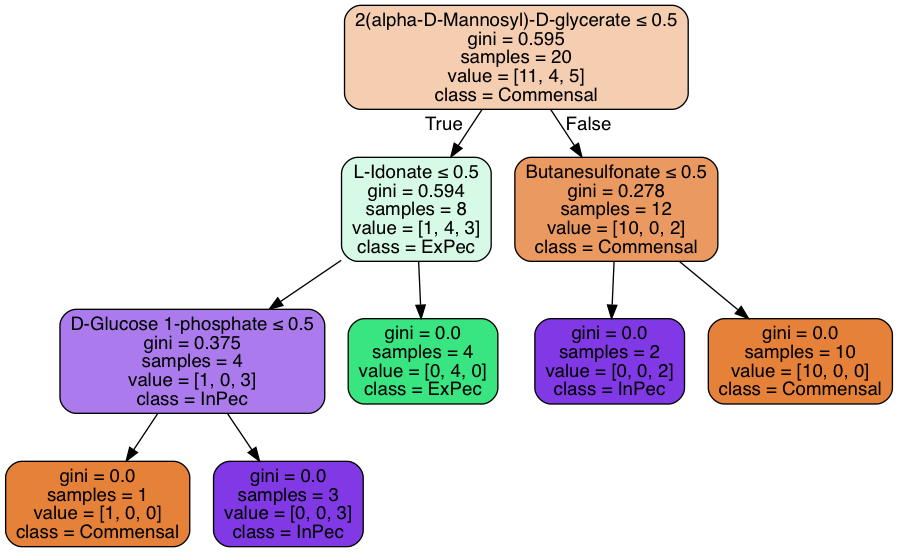

In [29]:
visualize_classification_tree(fit_classifier, filter_df)

## D) (If there is time left) Attempt the above analysis with phosphorous sources instead

- The default phosphorus source is phosphate (EX_pi_e). Set this bound to zero before modeling growth with the new phosphorus source

- The phosphorus sources are:

In [30]:
print(phosphorus_sources)

['EX_pi_e', 'EX_fmn_e', 'EX_amp_e', 'EX_g6p_e', 'EX_cbl1_e', 'EX_nmn_e', 'EX_f6p_e', 'EX_glyc3p_e', 'EX_gam6p_e', 'EX_minohp_e', 'EX_ppt_e', 'EX_gdp_e', 'EX_gtp_e', 'EX_fad_e', 'EX_adocbl_e', 'EX_23camp_e', 'EX_23cgmp_e', 'EX_23cump_e', 'EX_3amp_e', 'EX_3gmp_e', 'EX_3ump_e', 'EX_eca4colipa_e', 'EX_imp_e', 'EX_gmp_e', 'EX_ump_e', 'EX_enlipa_e', 'EX_hacolipa_e', 'EX_r5p_e', 'EX_glyc2p_e', 'EX_halipa_e', 'EX_cmp_e', 'EX_acgam1p_e', 'EX_glcur1p_e', 'EX_thrp_e', 'EX_dump_e', 'EX_gal1p_e', 'EX_dcmp_e', 'EX_23ccmp_e', 'EX_3cmp_e', 'EX_g3pe_e', 'EX_acgal1p_e', 'EX_tyrp_e', 'EX_uacgam_e', 'EX_udpacgal_e', 'EX_udpg_e', 'EX_udpgal_e', 'EX_udpglcur_e', 'EX_pser__L_e', 'EX_g3pc_e', 'EX_g3pg_e', 'EX_g3pi_e', 'EX_g3ps_e', 'EX_xmp_e', 'EX_damp_e', 'EX_dimp_e', 'EX_dgmp_e', 'EX_man6p_e', 'EX_g1p_e', 'EX_dtmp_e', 'EX_mepn_e']


In [31]:
phos_df = pandas.DataFrame()
for m in glob.glob('../qbio_resources/multi_strain_models/*.json'):
    model = cobra.io.load_json_model(m)
    model.reactions.EX_glc__D_e.lower_bound = 0
    print(model.id, model.name)
    for r_id in phosphorus_sources:
        if r_id not in model.reactions:
            continue
        r = model.reactions.get_by_id(r_id)

        r.lower_bound = -10
        phos_df.loc[r.id, model.id] = model.slim_optimize()
        r.lower_bound = 0

iAPECO1_1312 Escherichia coli APEC O1
iB21_1397 Escherichia coli BL21(DE3)
iBWG_1329 Escherichia coli BW2952
ic_1306 Escherichia coli CFT073
iE2348C_1286 Escherichia coli O127:H6 str. E2348/69
iEC042_1314 Escherichia coli 042
iEC55989_1330 Escherichia coli 55989
iECABU_c1320 Escherichia coli ABU 83972
iECB_1328 Escherichia coli B str. REL606
iECBD_1354 Escherichia coli 'BL21-Gold(DE3)pLysS AG'
iECD_1391 Escherichia coli BL21(DE3)
iECDH10B_1368 Escherichia coli str. K-12 substr. DH10B
iEcDH1_1363 Escherichia coli DH1
iECDH1ME8569_1439 Escherichia coli DH1
iEcE24377_1341 Escherichia coli E24377A
iECED1_1282 Escherichia coli ED1a
iECH74115_1262 Escherichia coli O157:H7 str. EC4115
iEcHS_1320 Escherichia coli HS
iECIAI1_1343 Escherichia coli IAI1
iECIAI39_1322 Escherichia coli IAI39


In [32]:
phos_filter_df = phos_df.copy()
phos_filter_df.fillna(0, inplace=True)
phos_filter_df[phos_filter_df < .1] = 0
phos_filter_df[phos_filter_df >= .1] = 1

In [33]:
phos_filter_df = phos_filter_df.T

In [34]:
map_dict = {'Commensal': 'r', 'ExPec': 'b', 'InPec': 'g'}

In [35]:
strain_color_dict = {}
for strain in strain_classification:
    strain_color_dict[strain] =  map_dict[strain_classification[strain]]

In [36]:
phos_row_colors = phos_filter_df.index.map(strain_color_dict)

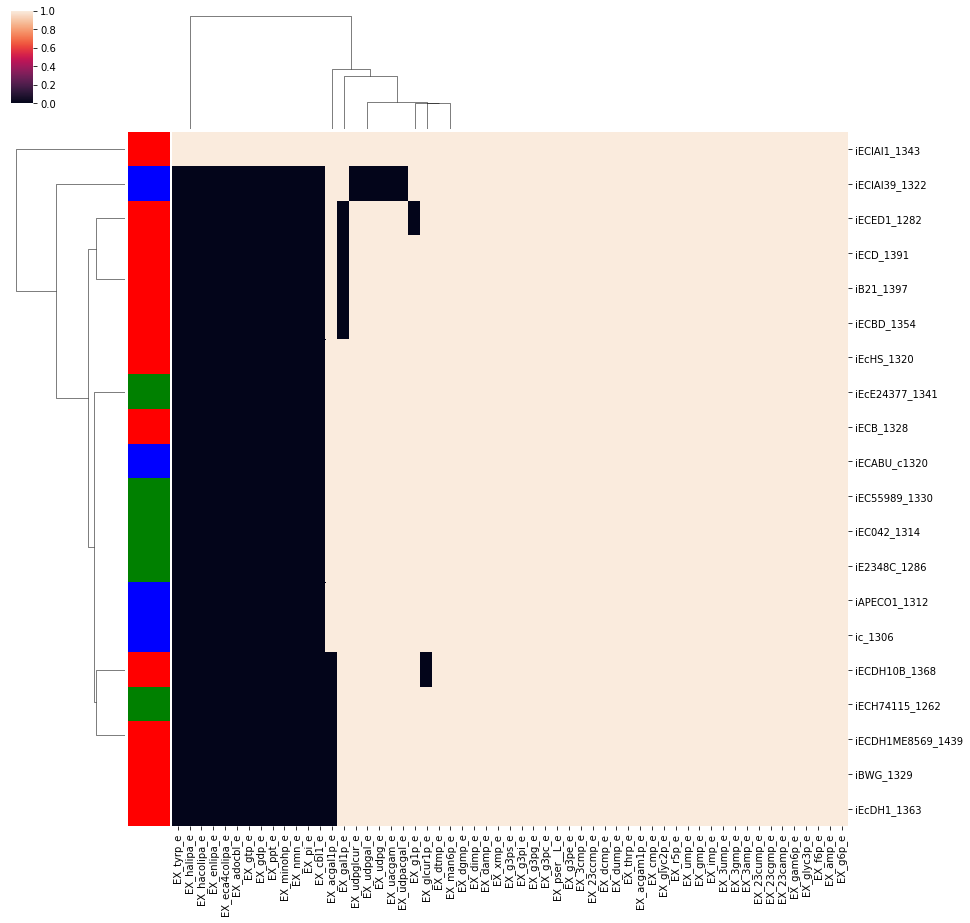

In [37]:
seaborn.clustermap(phos_filter_df,  figsize=(15, 15), row_colors=phos_row_colors)

In [38]:
map_dict = {'Commensal': 0, 'ExPec': 1, 'InPec': 2}

In [39]:
targets = []
for i in phos_filter_df.index:
    targets.append(map_dict[strain_classification[i]])

In [40]:
classifier = tree.DecisionTreeClassifier(max_depth=3)

In [41]:
phos_fit_classifier = classifier.fit(phos_filter_df, targets)

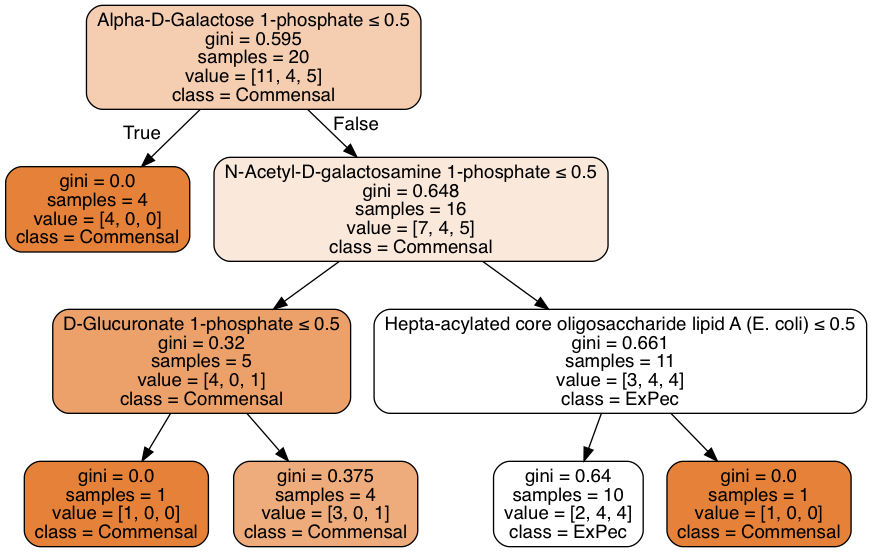

In [42]:
visualize_classification_tree(phos_fit_classifier, phos_filter_df)